###This notebook implements quanvolutional neural network (QCNN) for image classification using the PennyLane framework based on the code from https://pennylane.ai/qml/demos/tutorial_quanvolution/  

In [38]:
!pip install pennylane

In [39]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [52]:
#Setting of the main hyper-parameters of the model
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/')

# Set up path
USER_PATH = "/content/drive/MyDrive/ColabNotebooks"

SAVE_PATH = "/content/drive/MyDrive/ColabNotebooks"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

Mounted at /content/drive/


In [53]:
# Loading of the MNIST dataset

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [54]:
#Quantum circuit as a convolution kernel
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

###convolution scheme:

1.   the image is divided into squares of 2×2 pixels;
2.   each square is processed by the quantum circuit;
3.   the 4 expectation values are mapped into 4 different channels of a single output pixel.

In [55]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [56]:
# Quantum pre-processing of the dataset
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


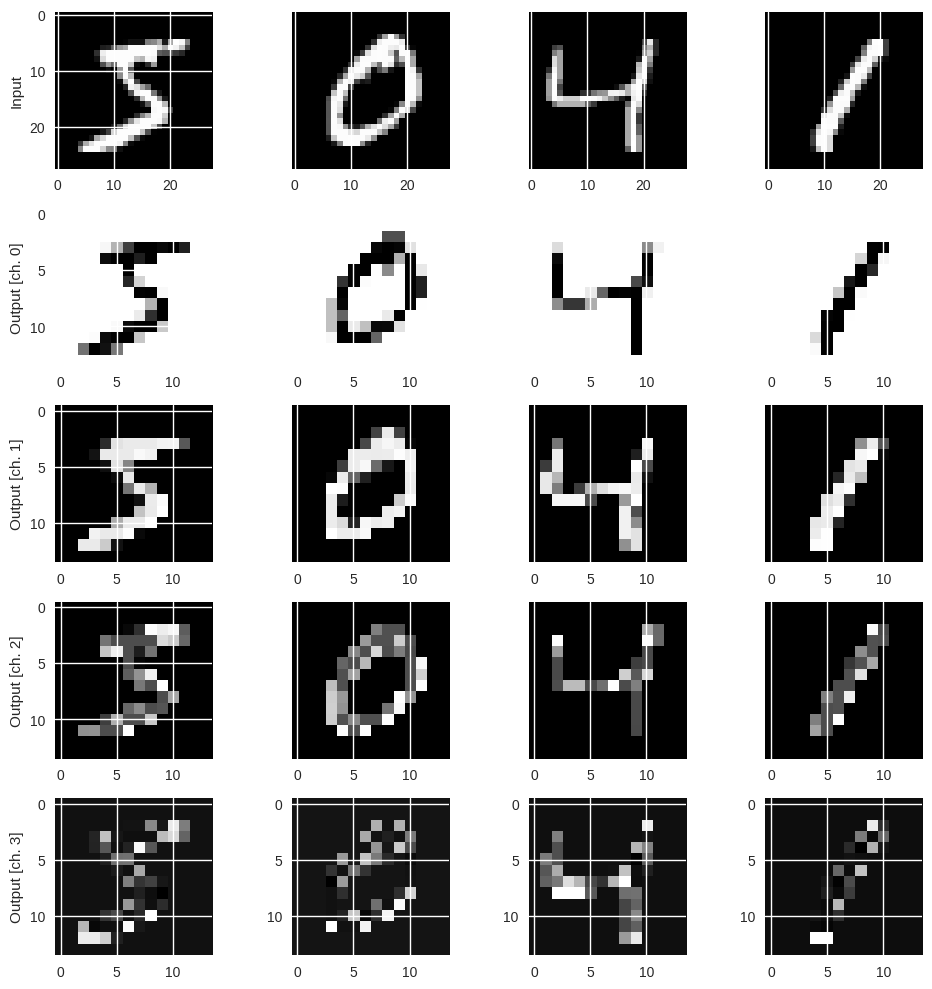

In [58]:
# visualize the effect of the quantum convolution layer on a batch of samples:

n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

###Hybrid quantum-classical model

The output features obtained from the quantum convolution layer are inputted into a classical neural network. This classical neural network is then trained to classify the ten different digits present in the MNIST dataset.

The classification is performed using a fully connected layer with ten output nodes, each equipped with a final softmax activation function. The model is compiled using a stochastic-gradient-descent optimizer and utilizes a cross-entropy loss function.

In [59]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [60]:
#training

q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.7193 - accuracy: 0.1400 - val_loss: 2.1909 - val_accuracy: 0.3333 - 723ms/epoch - 56ms/step
Epoch 2/30
13/13 - 0s - loss: 2.0989 - accuracy: 0.1800 - val_loss: 2.0694 - val_accuracy: 0.3333 - 62ms/epoch - 5ms/step
Epoch 3/30
13/13 - 0s - loss: 1.7309 - accuracy: 0.4200 - val_loss: 1.9759 - val_accuracy: 0.3333 - 68ms/epoch - 5ms/step
Epoch 4/30
13/13 - 0s - loss: 1.4012 - accuracy: 0.6000 - val_loss: 1.7451 - val_accuracy: 0.5667 - 68ms/epoch - 5ms/step
Epoch 5/30
13/13 - 0s - loss: 1.1718 - accuracy: 0.7200 - val_loss: 1.5894 - val_accuracy: 0.6000 - 65ms/epoch - 5ms/step
Epoch 6/30
13/13 - 0s - loss: 1.0024 - accuracy: 0.9000 - val_loss: 1.5615 - val_accuracy: 0.5667 - 67ms/epoch - 5ms/step
Epoch 7/30
13/13 - 0s - loss: 0.8035 - accuracy: 0.8800 - val_loss: 1.4717 - val_accuracy: 0.6000 - 62ms/epoch - 5ms/step
Epoch 8/30
13/13 - 0s - loss: 0.6612 - accuracy: 0.9400 - val_loss: 1.3812 - val_accuracy: 0.6000 - 67ms/epoch - 5ms/step
Epoch 9/30
13/13 - 0s 

In [61]:
# In order to compare the results achievable with and without the quantum convolution layer,
# we initialize a “classical” instance of the model that will be directly trained and validated with the raw MNIST images (i.e., without quantum pre-processing).

c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.3102 - accuracy: 0.1000 - val_loss: 2.3408 - val_accuracy: 0.1000 - 860ms/epoch - 66ms/step
Epoch 2/30
13/13 - 0s - loss: 1.9301 - accuracy: 0.2400 - val_loss: 2.1098 - val_accuracy: 0.2000 - 141ms/epoch - 11ms/step
Epoch 3/30
13/13 - 0s - loss: 1.6294 - accuracy: 0.5400 - val_loss: 1.9278 - val_accuracy: 0.4667 - 89ms/epoch - 7ms/step
Epoch 4/30
13/13 - 0s - loss: 1.3944 - accuracy: 0.8000 - val_loss: 1.7713 - val_accuracy: 0.5333 - 93ms/epoch - 7ms/step
Epoch 5/30
13/13 - 0s - loss: 1.1908 - accuracy: 0.9200 - val_loss: 1.6405 - val_accuracy: 0.6333 - 85ms/epoch - 7ms/step
Epoch 6/30
13/13 - 0s - loss: 1.0321 - accuracy: 0.9200 - val_loss: 1.5475 - val_accuracy: 0.7000 - 95ms/epoch - 7ms/step
Epoch 7/30
13/13 - 0s - loss: 0.8955 - accuracy: 0.9400 - val_loss: 1.4833 - val_accuracy: 0.7000 - 87ms/epoch - 7ms/step
Epoch 8/30
13/13 - 0s - loss: 0.7853 - accuracy: 0.9400 - val_loss: 1.4174 - val_accuracy: 0.6667 - 90ms/epoch - 7ms/step
Epoch 9/30
13/13 - 0

<ipython-input-62-c9eae5a580fe>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


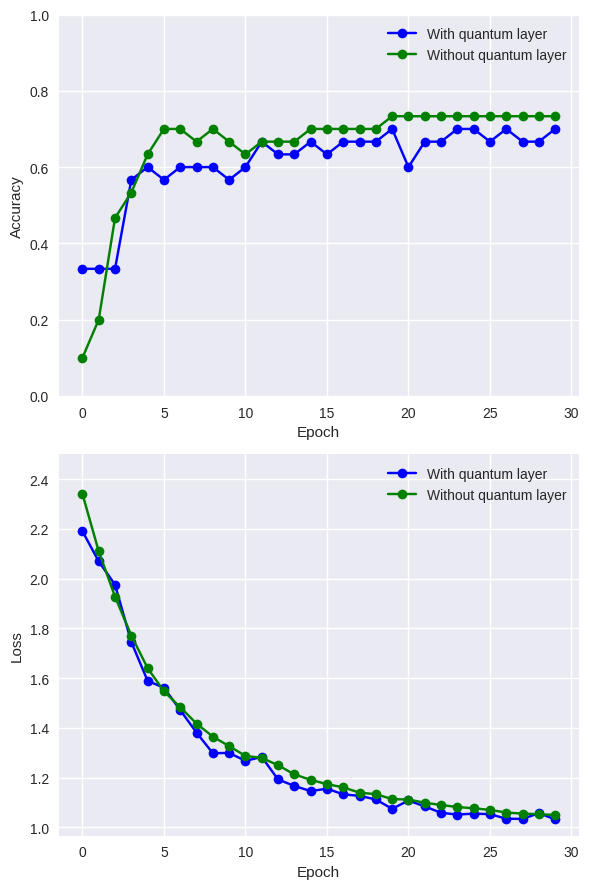

In [62]:
# plot the test accuracy and the test loss with respect to the number of training epochs.
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()